In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
%matplotlib inline
import seaborn as sns

In [3]:
# Read in data
referrals = pd.read_csv('../../Welcome-Centre-DataCorps-Data/referrals.csv', index_col=0)
clients = pd.read_csv('../../Welcome-Centre-DataCorps-Data/clients.csv', index_col=0)

/Users/davidsykes/anaconda/envs/data-analysis/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (44,46,47,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [116]:
# Parse datetime
referrals['ReferralTakenDate'] = pd.to_datetime(pd.to_datetime(referrals['ReferralTakenDate']).dt.date)

# Remove any double referrals in one day
referrals = referrals.reset_index().groupby(['ClientId', 'ReferralTakenDate']).first().reset_index()\
    .set_index('ReferralInstanceId')
    
referrals = referrals.sort_values('ReferralTakenDate')

# Create total referral count by Client
referral_count = referrals.groupby('ClientId').size()

# Add the referral order index
referral_no = referrals.assign(count=1).groupby('ClientId').expanding()['count'].sum()
referral_no = referral_no.reset_index().set_index('ReferralInstanceId').drop('ClientId', axis=1)
referrals['referral_no'] = referral_no

# Clip anything over 10
# referrals = referrals[referrals['referral_no'] < 10]

# Create label
y = referral_count.loc[referrals['ClientId']] >= 10

In [117]:
# Add a time since
referrals['time_since'] = referrals.groupby('ClientId')['ReferralTakenDate'].diff().dt.days
referrals['time_since'] = (1 / referrals['time_since']).fillna(0)

# Add a first dummy variable
referrals['first'] = referrals['referral_no'] == 1

In [5]:
# Include referral metadata as features
referral_reasons = referrals.filter(like='ReferralDomestic')
referral_document = referrals.filter(like='ReferralDocument')
referral_benefit = referrals.filter(like='ReferralBenefit')
referral_issue = referrals.filter(like='ReferralIssue')
referral_reason = referrals.filter(like='ReferralReason')
referral_agency = pd.get_dummies(referrals['ReferralAgencyId'])
general = referrals[['DependantNumber', 'LivingWithPartner']]

X = pd.concat([
    referral_reasons,
    referral_document,
    referral_benefit,
    referral_issue,
    referral_reason,
    referral_agency,
    general
], axis=1)

X = pd.concat([referrals[['time_since', 'first', 'referral_no']],
                  X], axis=1)

In [6]:
# Create Model Pipeline
pipe = Pipeline([
    ('imp', Imputer()),
    ('scale', StandardScaler()),
    ('cls', LogisticRegression())
])

In [23]:
# Fit Logistic Regression
param_grid = {
    'cls__C': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc', verbose=3)
gs.fit(X[['referral_no']], y)

Fitting 10 folds for each of 11 candidates, totalling 110 fits
[CV] cls__C=1e-05 ....................................................
[CV] ........................... cls__C=1e-05, score=0.622122 -   0.0s
[CV] cls__C=1e-05 ....................................................
[CV] ........................... cls__C=1e-05, score=0.764224 -   0.0s
[CV] cls__C=1e-05 ....................................................
[CV] ........................... cls__C=1e-05, score=0.810340 -   0.0s
[CV] cls__C=1e-05 ....................................................
[CV] ........................... cls__C=1e-05, score=0.820961 -   0.0s
[CV] cls__C=1e-05 ....................................................
[CV] ........................... cls__C=1e-05, score=0.818544 -   0.0s
[CV] cls__C=1e-05 ....................................................
[CV] ........................... cls__C=1e-05, score=0.842404 -   0.0s
[CV] cls__C=1e-05 ....................................................
[CV] .........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.764224 -   0.0s
[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.810340 -   0.0s
[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.820961 -   0.0s
[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.818544 -   0.0s
[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.842404 -   0.0s
[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.802757 -   0.0s
[CV] cls__C=0.0001 ...................................................
[CV] .......................... cls__C=0.0001, score=0.843830 -   0.0s
[CV] c

[CV] ............................ cls__C=10.0, score=0.858157 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] ........................... cls__C=100.0, score=0.622122 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] ........................... cls__C=100.0, score=0.764224 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] ........................... cls__C=100.0, score=0.810340 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] ........................... cls__C=100.0, score=0.820961 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] ........................... cls__C=100.0, score=0.818544 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] ........................... cls__C=100.0, score=0.842404 -   0.0s
[CV] cls__C=100.0 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    2.1s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('cls', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'cls__C': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03,   1.00000e+04,   1.00000e+05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=3)

In [24]:
gs.best_score_


0.80175768051883423

In [38]:
del score_by_number

### Plot the AUC score for each referral number

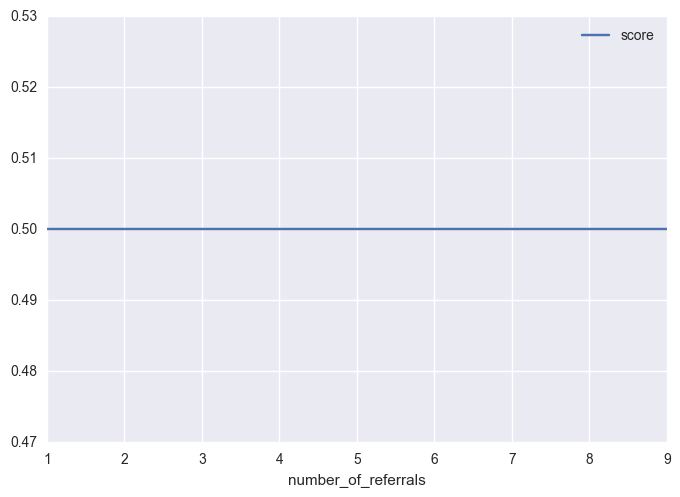

In [43]:
def plot_auc_for_each_referral(gridsearch, X, y, variables_list):
    score_by_number = X.copy()
    score_by_number['label'] = y.values
    score_by_number['prob_score'] = gridsearch.predict_proba(X[variables_list])[:,1]
    score_by_number['referral_no'] = X['referral_no'].copy()
    plot_series = []
    for k,g in score_by_number.groupby('referral_no'):
        score  = roc_auc_score(g['label'], g['prob_score'])
        plot_series.append((k, score))
    ax = pd.DataFrame(plot_series, columns=['number_of_referrals',
                                            'score']).plot(x='number_of_referrals', y='score')
    return ax
    
plot_auc_for_each_referral(gs, X, y, ['referral_no'])

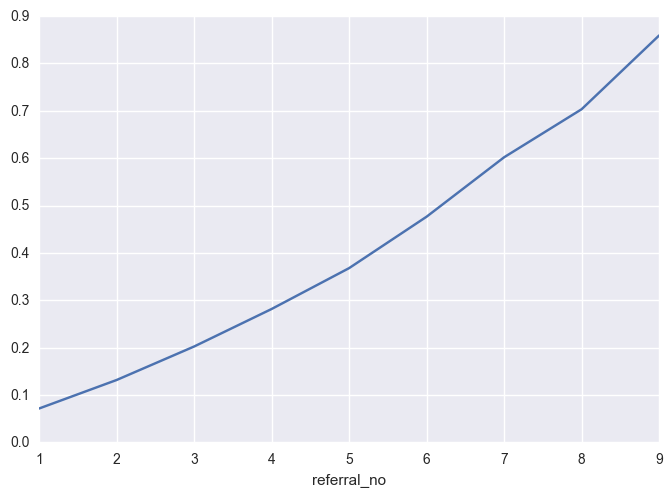

In [26]:
# Plot probability of reaching 10 based on current referral
y.index = referrals.index
ax = y.groupby(referrals['referral_no']).mean().plot()
y.groupby(referrals['referral_no']).mean().to_clipboard()

###  Include time since and first to model

In [32]:
param_grid = {
    'cls__C': np.logspace(-5,5,11)
}
gs2 = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc', verbose=0)
gs2.fit(X[['time_since', 'first']], y)
print(gs2.best_score_)

0.694266832062


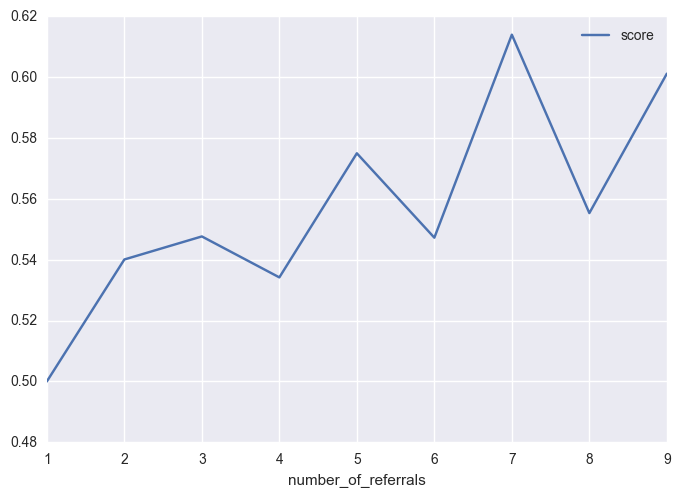

In [44]:
plot_auc_for_each_referral(gs2, X, y, ['time_since', 'first'])

#  Include more Features

- Time since last 
- EWM stuff 
- Categorical things - reason, age, dependents
- Packs taken
- Agency
- Referral Issue

In [45]:
param_grid = {
    'cls__C': np.logspace(-5,5,11)
}
gs = GridSearchCV(pipe, param_grid, cv=10, scoring='roc_auc', verbose=0)
gs.fit(X, y)
print(gs.best_score_)

0.822985938817


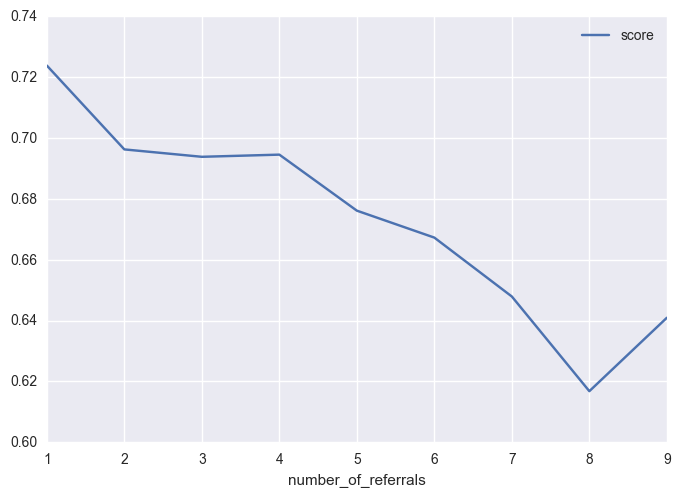

In [48]:
plot_auc_for_each_referral(gs, X, y, X.columns)

In [65]:
gs.best_estimator_

Pipeline(steps=[('imp', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('cls', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [86]:
score = [i[1] for i in gs.best_estimator_.predict_proba(X)]

see_cath_check = pd.DataFrame({'SeeingCath':referrals['ClientIssue_DW(Cath) supporting/supported'].fillna(0),
             'Label':y.values,
             'Probability_Score':score})


In [87]:
see_cath_check.groupby('SeeingCath').mean()

,Label,Probability_Score
SeeingCath,,
0.0,0.215573,0.291495
1.0,0.605455,0.419669


In [88]:
roc_auc_score(see_cath_check['SeeingCath'], see_cath_check['Label'])

0.6949409815696832

In [118]:
referrals['ClientIssue_DW(Cath) supporting/supported'] = referrals['ClientIssue_DW(Cath) supporting/supported'].fillna(0)
referrals['DependentLabel'] = y.values

In [113]:
(referrals.groupby(['DependentLabel', 'ClientIssue_DW(Cath) supporting/supported']).ClientId.nunique()).unstack().to_clipboard()

In [104]:
clients.index.nunique()

5691

In [120]:
referrals.groupby('ClientIssue_DW(Cath) supporting/supported').nunique()['ClientId']

ClientIssue_DW(Cath) supporting/supported
0.0    5291
1.0      85
Name: ClientId, dtype: int64

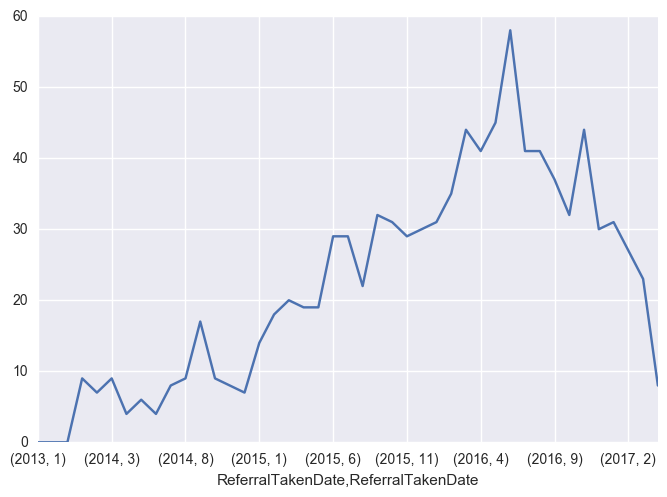

In [124]:
referrals.groupby([referrals.ReferralTakenDate.dt.year,
                 referrals.ReferralTakenDate.dt.month]).sum()['ClientIssue_DW(Cath) supporting/supported'].plot()